# Lecture 5: Common Random Variables and How to Sample Them

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pseudo-random Number Generators (PRNG)

PRNG's are used to generate random integers between zero and a maximum number, say $m$.

### The middlesquare algorithm (Von Neumann)

1. Take a number and square it.
2. Pad the result with zeros to get to the desired number of digits.
3. Take the middle digits of the resulting number.
4. Repeat.

Here is an implementation using strings.

In [2]:
def middlesquare(s, digits=4):
    # Square the number
    s2 = s ** 2
    # Turn the resulting number into a string padding with zeros to get to the desired number of digits
    s2_str = str(s2).zfill(2*digits)
    # Keep only the middle
    middle_str = s2_str[digits/2:][:-digits/2]
    return int(middle_str)

In [3]:
seed = 1234
s = seed
for _ in range(20):
    s = middlesquare(s, digits=4)
    print s

5227
3215
3362
3030
1809
2724
4201
6484
422
1780
1684
8358
8561
2907
4506
3040
2416
8370
569
3237


Unfortunately, the middlesquare algorithms results in periodic sequences with very small period. For example:

In [4]:
seed = 540
s = seed
for _ in range(20):
    s = middlesquare(s, digits=4)
    print s

2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540


### Linear Congruential Generator (LCG)
The linear congruential generator works as follows. You pick three big integers $a$, $b$ and $m$.
Pick a seed $x_0$.
Then iterate:
$$
x_{i+1} = (a x_i + b)\mod m
$$

In [5]:
def lcg(x, a=123456, b=978564, m=6012119):
    return (a * x + b) % m

In [6]:
seed = 1234
s = seed
for _ in range(20):
    s = lcg(s)
    print s

3020293
2650792
5494308
965075
3115541
1883116
317849
243995
2909094
134725
4067010
1658958
451558
4155644
2001482
3861575
4605659
1061643
2982572
5159241


The good thing about LCG is that you can prove a lot of stuff about it using group theory and that you know that the maximum possible number is $m$.

### Mersenne Twister PRNG
Numpy uses the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) to generate random numbers.
Its details are more complicated than LCG, but it is still initialized by an integer seed.
You can test it as follows:

In [7]:
# set the seed
np.random.seed(12345)
# print 5 integers from 0 to 6012119
for _ in range(5):
    print np.random.randint(0, 6012119)

1396132
2993577
1134974
5664101
3555874


In [8]:
# see what the seed does - Here is what happens if you rerun the code above:
for _ in range(5):
    print np.random.randint(0, 6012119)

5290753
4246897
3579195
3692649
3755099


In [9]:
# And here is what happens if you reset the seed to its original value and rerun the code
np.random.seed(12345)
for _ in range(5):
    print np.random.randint(0, 6012119)

1396132
2993577
1134974
5664101
3555874


So, resetting the seed gives you the same sequence. In your numerical simulations you should always set the seed by hand in order to ensure the reproducibility of your work.

## Sampling from the uniform distribution

If we have a PRNG that samples between zero and a big integer, say $m$, we can create a generator that samples from the uniform distribution.
If $d$ is the sample from the PRNG, then
$$
x = \frac{d}{m},
$$
is approximately uniformly distributed.
Let's experiment with this idea.

In [10]:
# The maximum integer
m = 6012119

# First a uniform random generator based on lcg
lcg_seed = 123456 # A seed of lcg
lcg_state = lcg_seed # Internal state of lcg
def unif_lcg():
    global lcg_state
    lcg_state = lcg(lcg_state)
    return lcg_state / (1. * m) # The 1. in the denominator ensures
                                # that the division is done in floating point arithmetic
print 'LCG Uniform Samples:'
for _ in range(5):
    print unif_lcg()

# And let's also do it with Mersenne Twister from numpy
np.random.seed(123456)
def unif_mt():
    return np.random.randint(0, m) / (1. * m)
print '\nMT Uniform Samples:'
for _ in range(5):
    print unif_mt()

LCG Uniform Samples:
0.272921244573
0.9279352255
0.333964613808
0.0981274655409
0.587151052732

MT Uniform Samples:
0.0119333965279
0.886823763801
0.507485630274
0.530072508545
0.537322531374


Which one of the two is better? There are many statistical tests that we would like our uniform random number generator to go through. First (and most importantly) the empirical histograms of the generated numbers should be uniform. Let's test this.

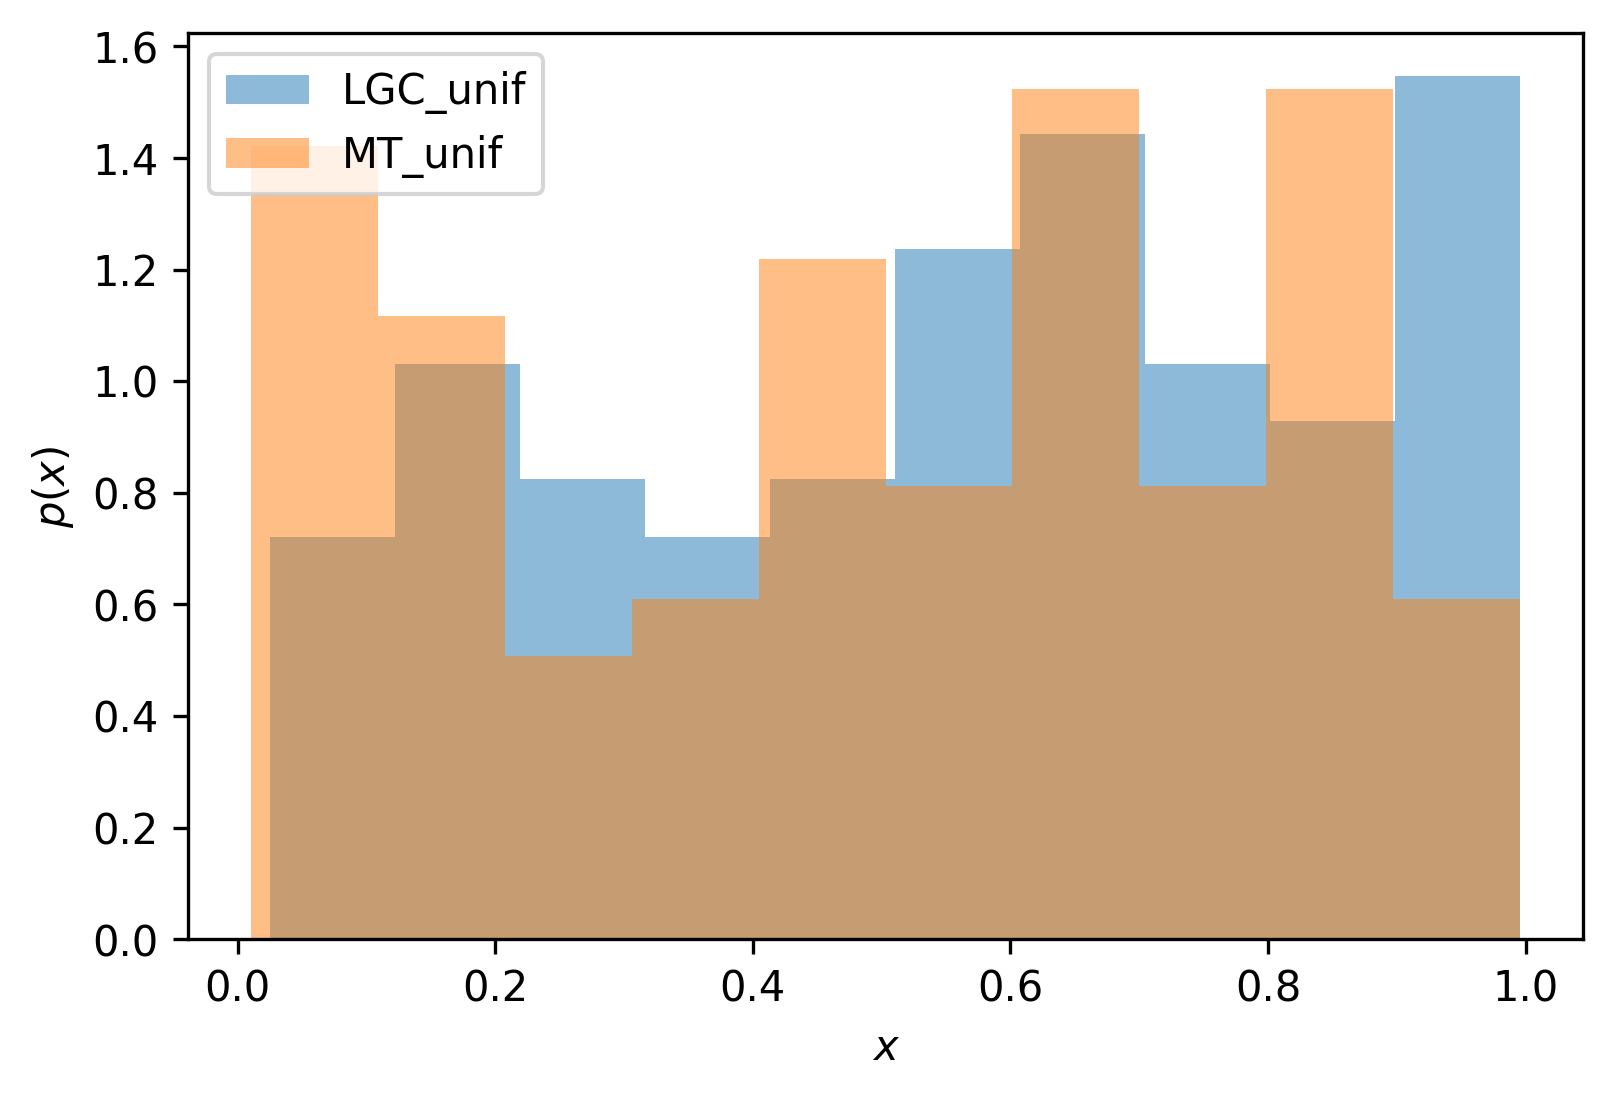

In [11]:
# How many numbers to sample:
N = 100
lcg_X = [unif_lcg() for _ in range(N)]
mt_X = [unif_mt() for _ in range(N)]
# Plot the histograms
fig, ax = plt.subplots()
ax.hist(lcg_X, normed=True, alpha=0.5, label='LGC_unif')
ax.hist(mt_X, normed=True, alpha=0.5, label='MT_unif')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.legend(loc='best')

### Question 01
+ Hmm, we probably need to increase the number of samples to observe this statistic better. Increase $N$ from 100 to $1,000$ and then to $10,000$. How do the distributions look like now?

+ A second thing that we would like to test is whether or not consecutive numbers are all independent (Idependent identically distributed). Unfortunately, we need more theory than we know to do this.

+ For future reference, note that you should not really use ``unif_mt`` to generate uniform random numbers. Numpy already implements this in ``numpy.random.rand``. We provide an example right below. 

In [12]:
# Generate some random numbers with numpy's unif_mt:
X = np.random.rand(10)
print X

[ 0.15584706  0.86260898  0.6830463   0.0857089   0.56610253  0.14982485
  0.47745445  0.84893827  0.14014442  0.32955081]


## The Bernoulli Distribution
The Bernoulli distribution arises from a binary random variable representing the outcome of an experiment with a given probability of success.
Let us encode success with 1 and failure with 0.
Then, we say that the random variable
$$
X\sim\mathcal{B}(\theta),
$$
is a Bernoulli random variable with parameter $\theta$ if:
$$
X = \begin{cases}
1,\;\text{with probability}\;\theta,\\
0,\;\text{otherwise}.
\end{cases}
$$
Another way to write the same thing is through the probability density function of $X$:
$$
p(x) = \theta \delta(x-1) + (1-\theta)\delta(x),
$$
where we used Dirac's delta to talk about point masses.
To sample from it, we do the following steps:

+ Sample a uniform number $u$ (i.e., a number of $\mathcal{U}([0,1])$).

+ If $u\le \theta$, then set $x = 1$.

+ Otherwise, set $x = 0$.

Let's see if this process does indeed produce the desired result.

In [13]:
def sample_bernoulli(theta):
    u = np.random.rand()
    if u <= theta:
        return 1
    return 0

for _ in range(10):
    print sample_bernoulli(0.3)

0
0
0
0
0
0
0
0
0
0


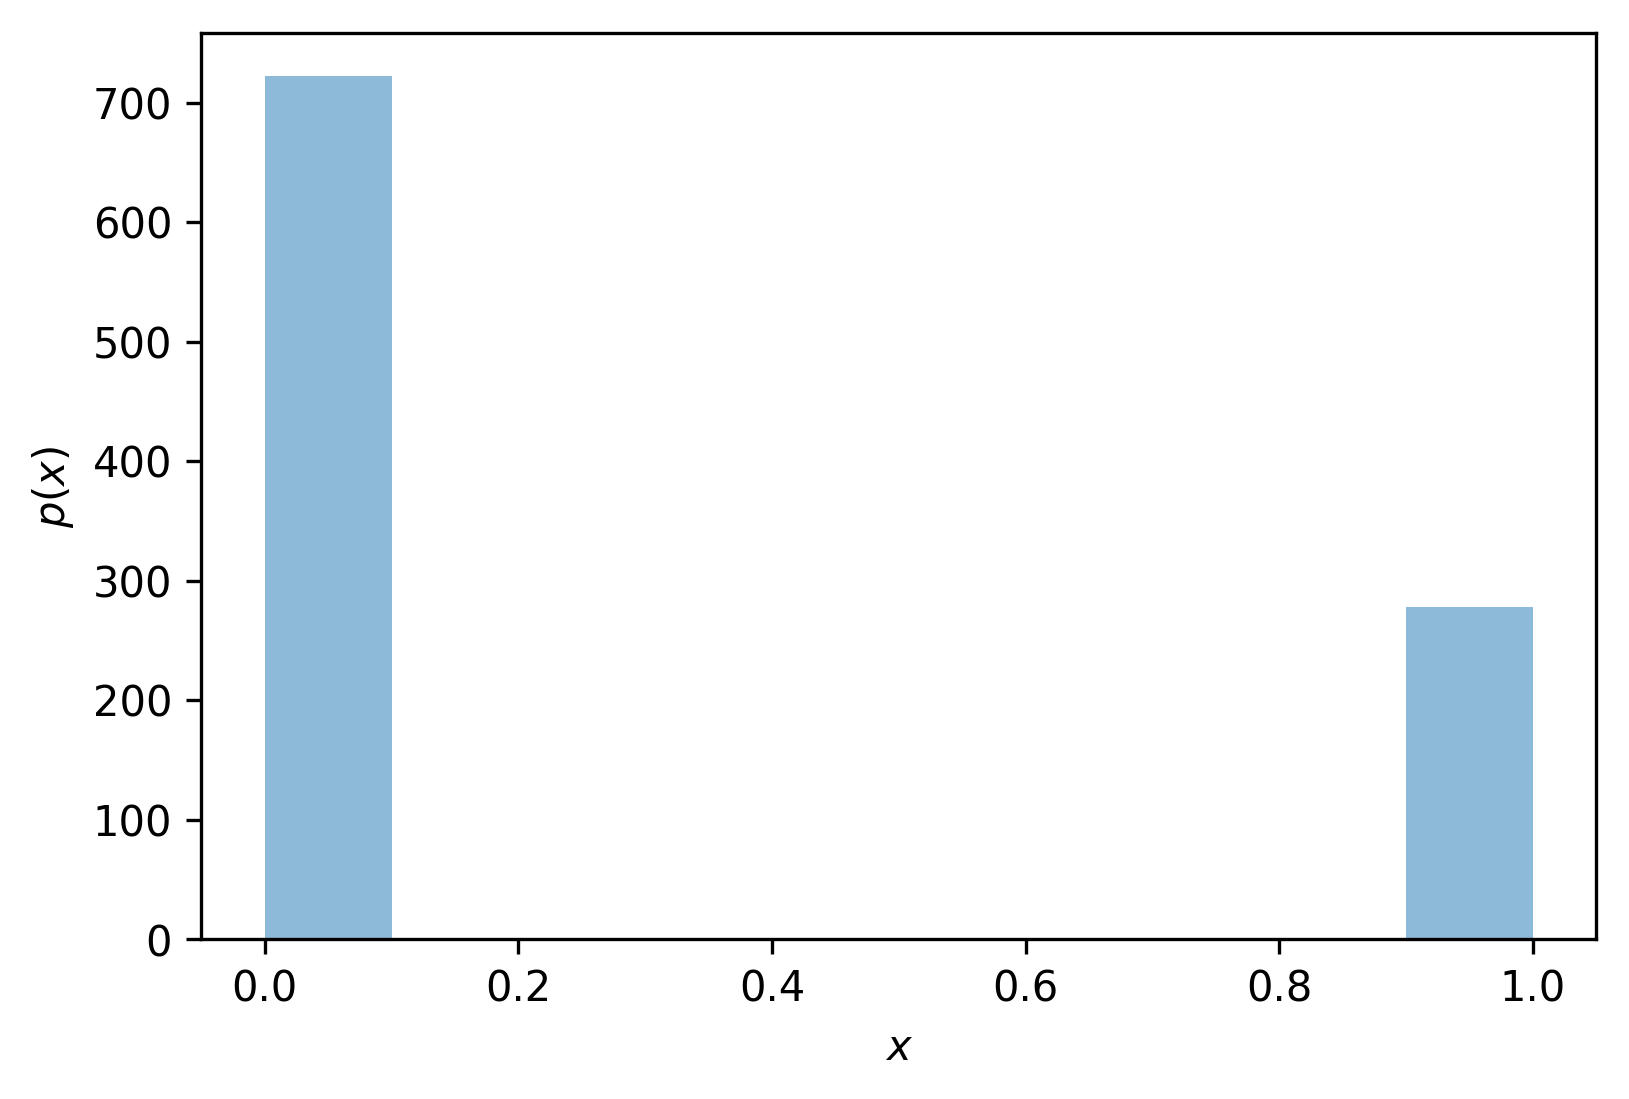

In [14]:
# Let's do a histogram like before
N = 1000
X = [sample_bernoulli(0.3) for _ in range(N)]
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

Ok, it looks fine. About $\theta N$ samples went to 1 and $(1-\theta)N$ samples went to 0.

## Sampling Discrete Distributions
Consider a generic discrete random variable $X$ taking $m$ different values.
Without loss of generality, you may assume that these values are integers $\{0, 1,2,\dots,m-1\}$ (they are just the labels of the discrete objects anyway).
Let us assume that
$$
p(X=k) = p_k,
$$
where, of course, we must have:
$$
p_k \ge 0,
$$
and
$$
\sum_{k=0}^{m-1} p_k = 1.
$$
Remember, that an succint way to write this is using the Dirac delta:
$$
p(x) = \sum_{k=0}^{m-1}p_k\delta(x-k).
$$
In any case, here is how you sample from such a distribution:

+ Draw a uniform sample $u$.
+ Find the index $j\in\{0,1,\dots,m-1\}$ such that:
$$
\sum_{k=0}^{j-1}p_k \le u < \sum_{k=0}^j.
$$
+ Then, your sample is $j$.

Let's code it.

In [15]:
def sample_discrete(p):
    """
    Sample from a discrete probability density.
    
    :param p: An array specifying the probability of each possible state.
              The number of states ``m=len(p)``.
    :returns: A random integer.
    
    (btw this is how you document a python function)
    """
    m = len(p)
    u = np.random.rand()
    c = 0.
    for j in range(m):
        c += p[j]
        if u <= c:
            return j

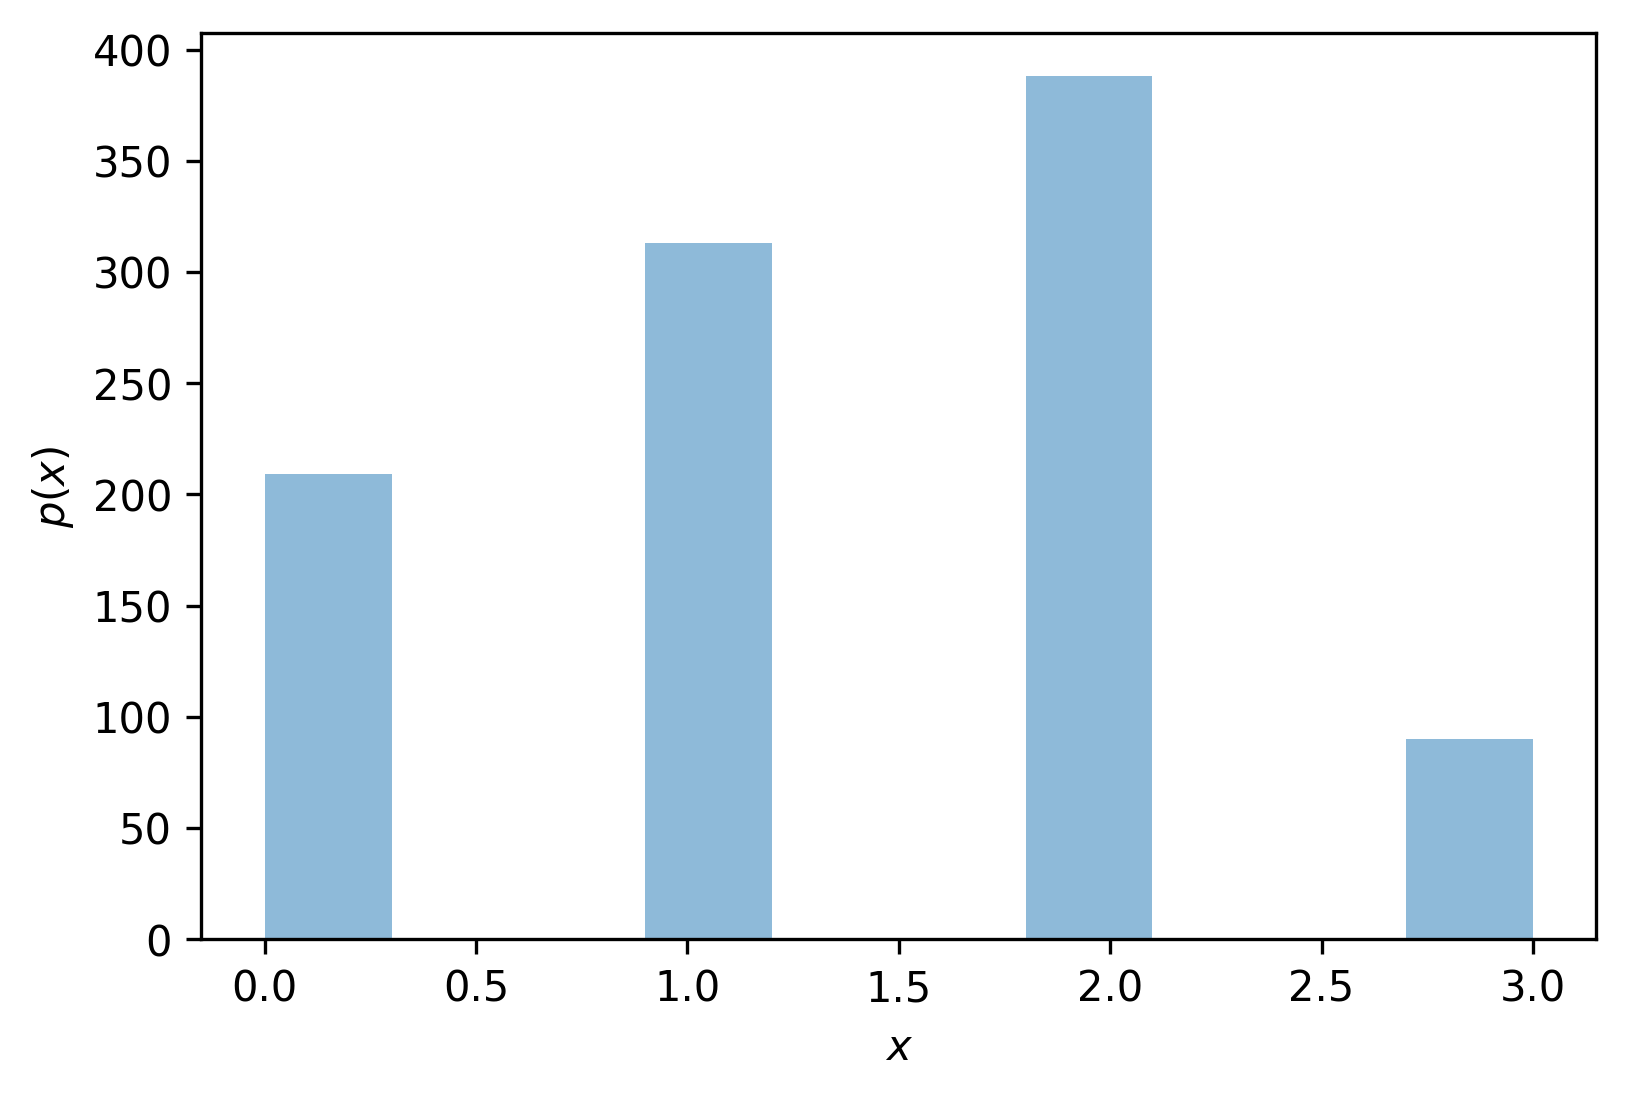

In [16]:
# Let's test it with a four-state discrete random variable with probabilities
p = [0.2, 0.3, 0.4, 0.1]
# Let's take 1,000 samples
N = 1000
X = [sample_discrete(p) for _ in range(N)]
# and do the empirical histrogram
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

Of course, numpy already implements this functionality. Here is how to do the same thing numpy:

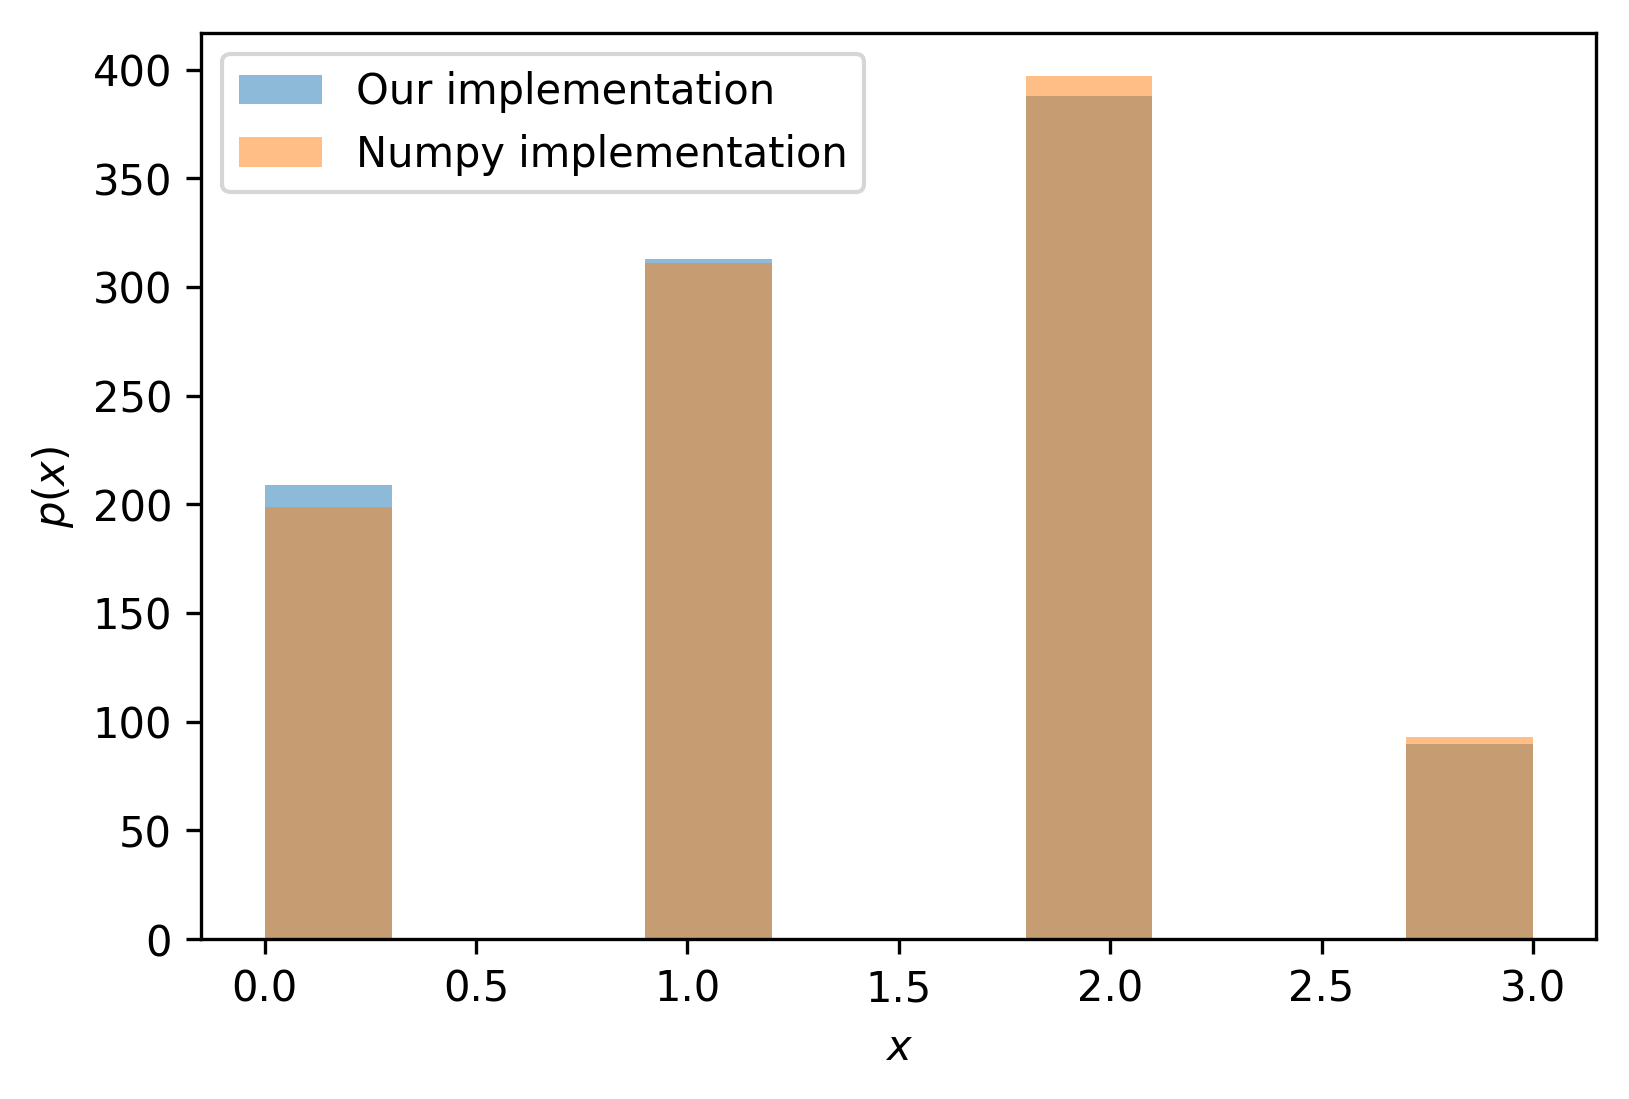

In [17]:
X_np = np.random.choice(np.arange(4), # The objects that you want to sample (here integers, 0,1,2,3)
                        p=p,          # The probability of sampling each object
                        size=N        # How many samples you want  
                       )
# Let's compare the two histograms
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5, label='Our implementation')
ax.hist(X_np, alpha=0.5, label='Numpy implementation')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.legend(loc='best')

## The Binomial Distribution

The Binomial distribution gives you the number of successes in $N$ tries of a random experiment with probability of success $\theta$.
We write:
$$
X\sim \mathcal{B}(N,\theta).
$$
You can easily simulate it (excersize) by noticing that:
$$
X = \sum_{i=1}^N X_i,
$$
where
$$
X_i \sim \mathcal{B}(\theta),
$$
are indepdent Bernoulli trials.
We can also show that:
$$
p(X=k) = \left(\begin{array}{c}N\\ k\end{array}\right)\theta^k(1-\theta)^{N-k}.
$$
Let's plot this distribution for various $N$'s.
We will use the built-in ``scipy.stats`` functionality for this one.
For your future reference, you can find it [here](https://docs.scipy.org/doc/scipy/reference/stats.html).

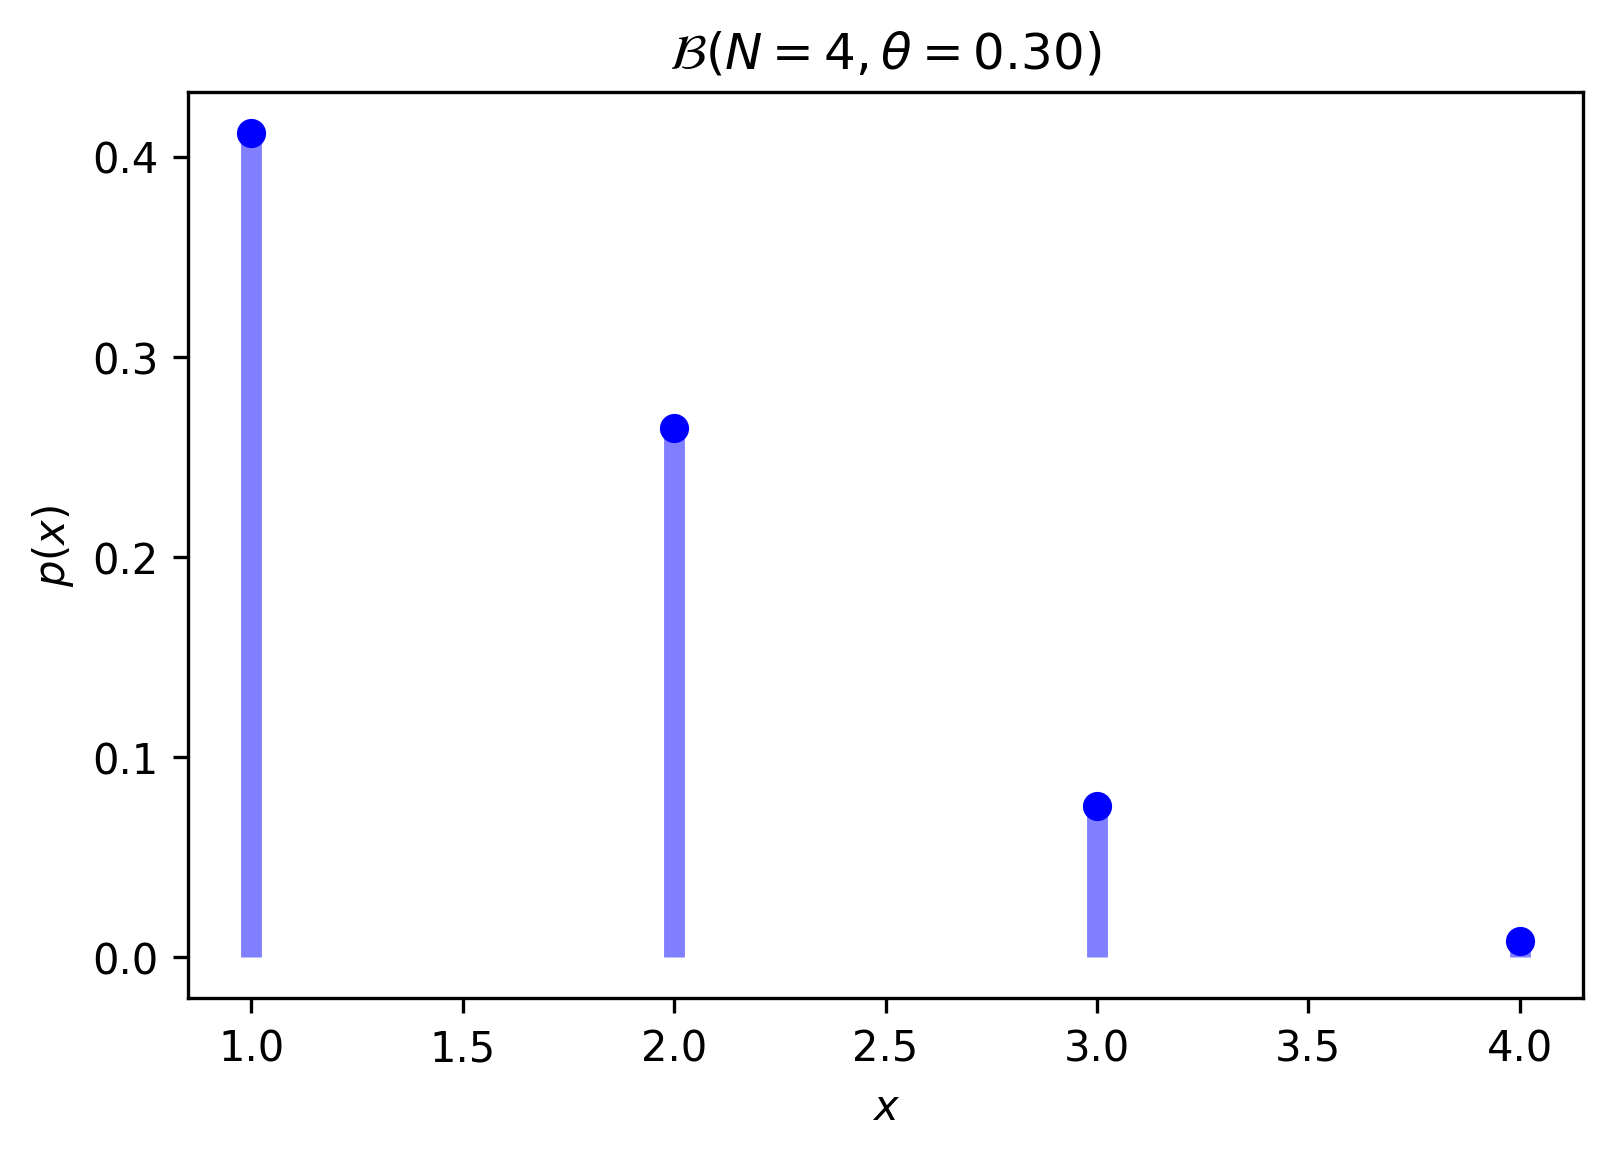

In [18]:
import scipy.stats as st

def plot_binom_pdf(N, theta):
    k = np.arange(N) + 1. # From 1 to N
    p_k = st.binom(N, theta).pmf(k) # pmf is short for probability mass function
                                    # which is the right terminology for a discrete variable
                                    # (i.e., we use 'mass' instead of 'density')
    fig, ax = plt.subplots()
    ax.plot(k, p_k, 'o', color='b')
    ax.vlines(k, 0, p_k, colors='b', lw=5, alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_title(r'$\mathcal{B}(N=%d, \theta=%.2f)$' % (N, theta)) # the 'r' is required to render
                                                                   # '\' character correctly
    
plot_binom_pdf(4, 0.3)

Ok, now let's play with $N$.

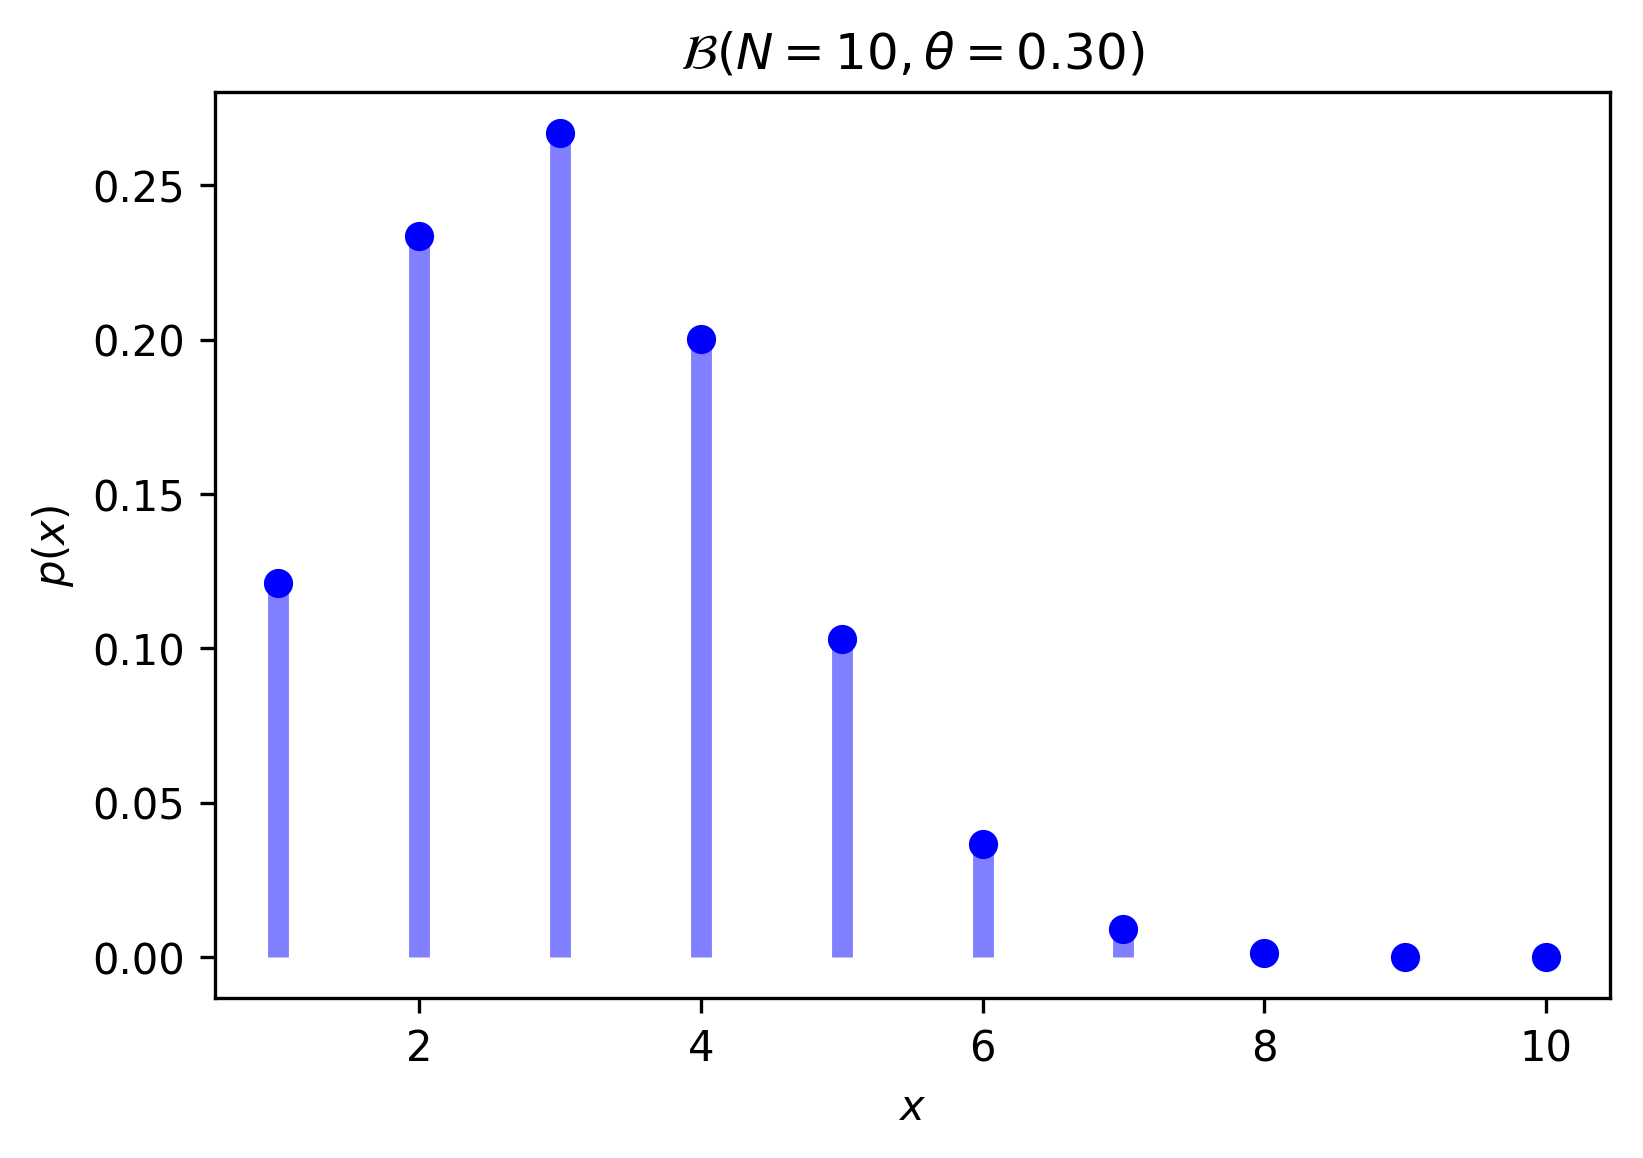

In [19]:
plot_binom_pdf(10, 0.3)

### Question 02
+ Start increasing $N$. Try really big numbers. Does the result remind you a familiar distribution?

+ Play a little bit with $\theta$. What happes as you move it around?

## Inverse Sampling
How do you sample an arbitrary univariate continuous random variable $X$ with CDF $F(x)$.
In this scenario, *inverse sampling* is the way to go.
It relies on the observation that the random variable
$$
Y = F^{-1}(U),
$$
where $F^{-1}$ is the inverse of the CDF of $X$ and $U\sim\mathcal{U}([0,1])$ has exactly the same distribution as $X$.

We will demonstrate this by exmaple. To this end, let us consider an exponential random variable:
$$
T \sim \mathcal{r},
$$
where $r > 0$ is known as the *rate parameter*.
The exponential distribution describes the time it passes between random events that occur at a constnat rate $r$.
Its CDF is:
$$
p(t) = re^{-rt},
$$
and its CFG is:
$$
F(t) = p(T\le t) = 1 - e^{-rt}.
$$
We plot it next.

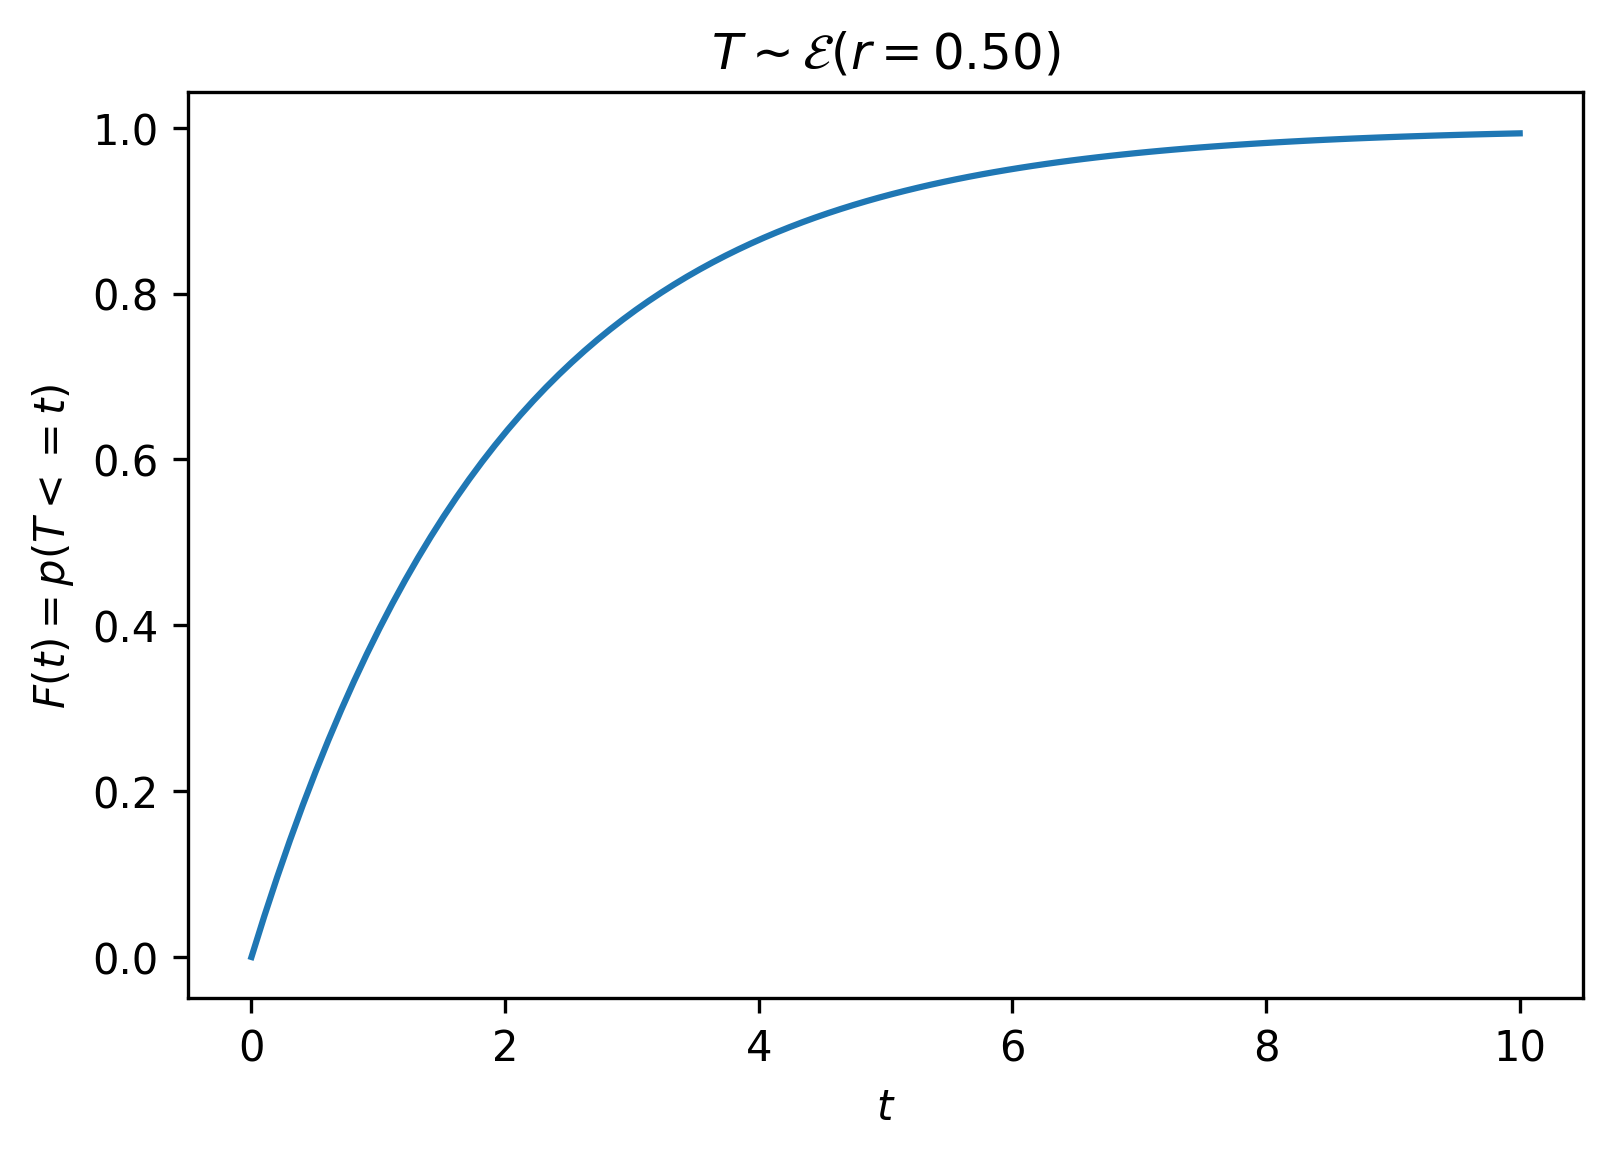

In [20]:
r = .5 # Events occur every 0.5 minutes
fig, ax = plt.subplots()
t = np.linspace(0., 5. / r, 100)
ax.plot(t, st.expon(scale=1./r).cdf(t))
ax.set_xlabel('$t$')
ax.set_ylabel(r'$F(t) = p(T <= t)$')
ax.set_title(r'$T\sim\mathcal{E}(r=%.2f)$' % r)

To sample $T$ using inverse sampling, we need the inverse of the CDF. This is easily shown to be:
$$
F^{-1}(u) = -\frac{\ln(1-u)}{r}.
$$
Let's see if this is going to give us the right samples.
We will compare the empirical histogram obtained by inverse sampling to the actual PDF $p(t)$.

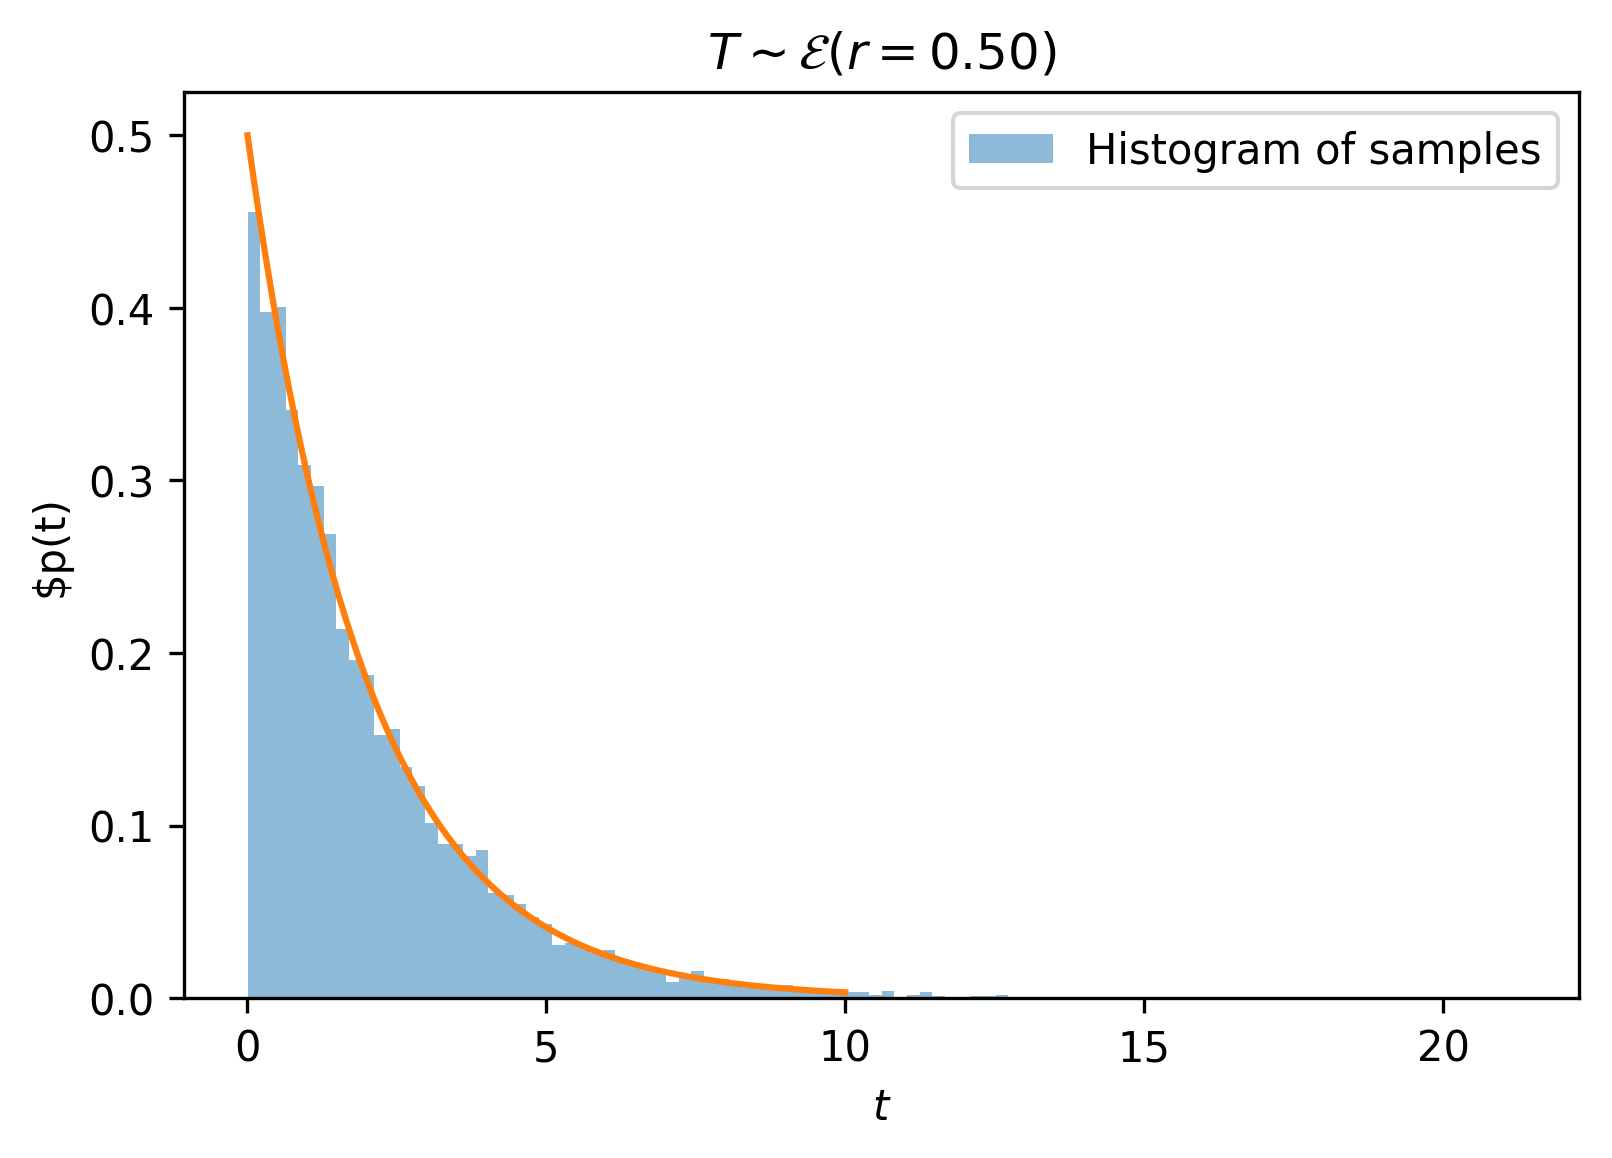

In [21]:
def sample_exp(r):
    u = np.random.rand()
    return -np.log(1. - u) / r

N = 10000
T = [sample_exp(r) for _ in range(N)]
fig, ax = plt.subplots()
ax.hist(T, alpha=0.5, normed=True, bins=100, label='Histogram of samples')
ax.plot(t, st.expon(scale=1./r).pdf(t))
ax.set_xlabel('$t$')
ax.set_ylabel('$p(t)')
ax.set_title(r'$T\sim\mathcal{E}(r=%.2f)$' % r)
plt.legend(loc='best')

### Questions 03

+ Implement inverse sampling for a univariate Gaussian with zero mean and unit variance. Use ``scipy.stats`` to find the inverse CDF of the Gaussian (It is ``st.norm.ippf``).

## The Central Limit Theorem
Consider, $X_1,X_2,\dots$ be iid random variables with mean $\mu$ and variance $\sigma^2$.
Define their sum:
$$
S_N = \frac{X_1+\dots+X_N}{N}.
$$
The Central Limit Theorem (CLT), states that:
$$
S_N \sim \mathcal{N}(S_N|\mu, \frac{\sigma^2}{N}),
$$
for large $N$.
That is, they start to look like Gaussian.
Let's test it for the Exponential distribution.
We will use ``numpy.random.exponential`` to sample from the exponential.

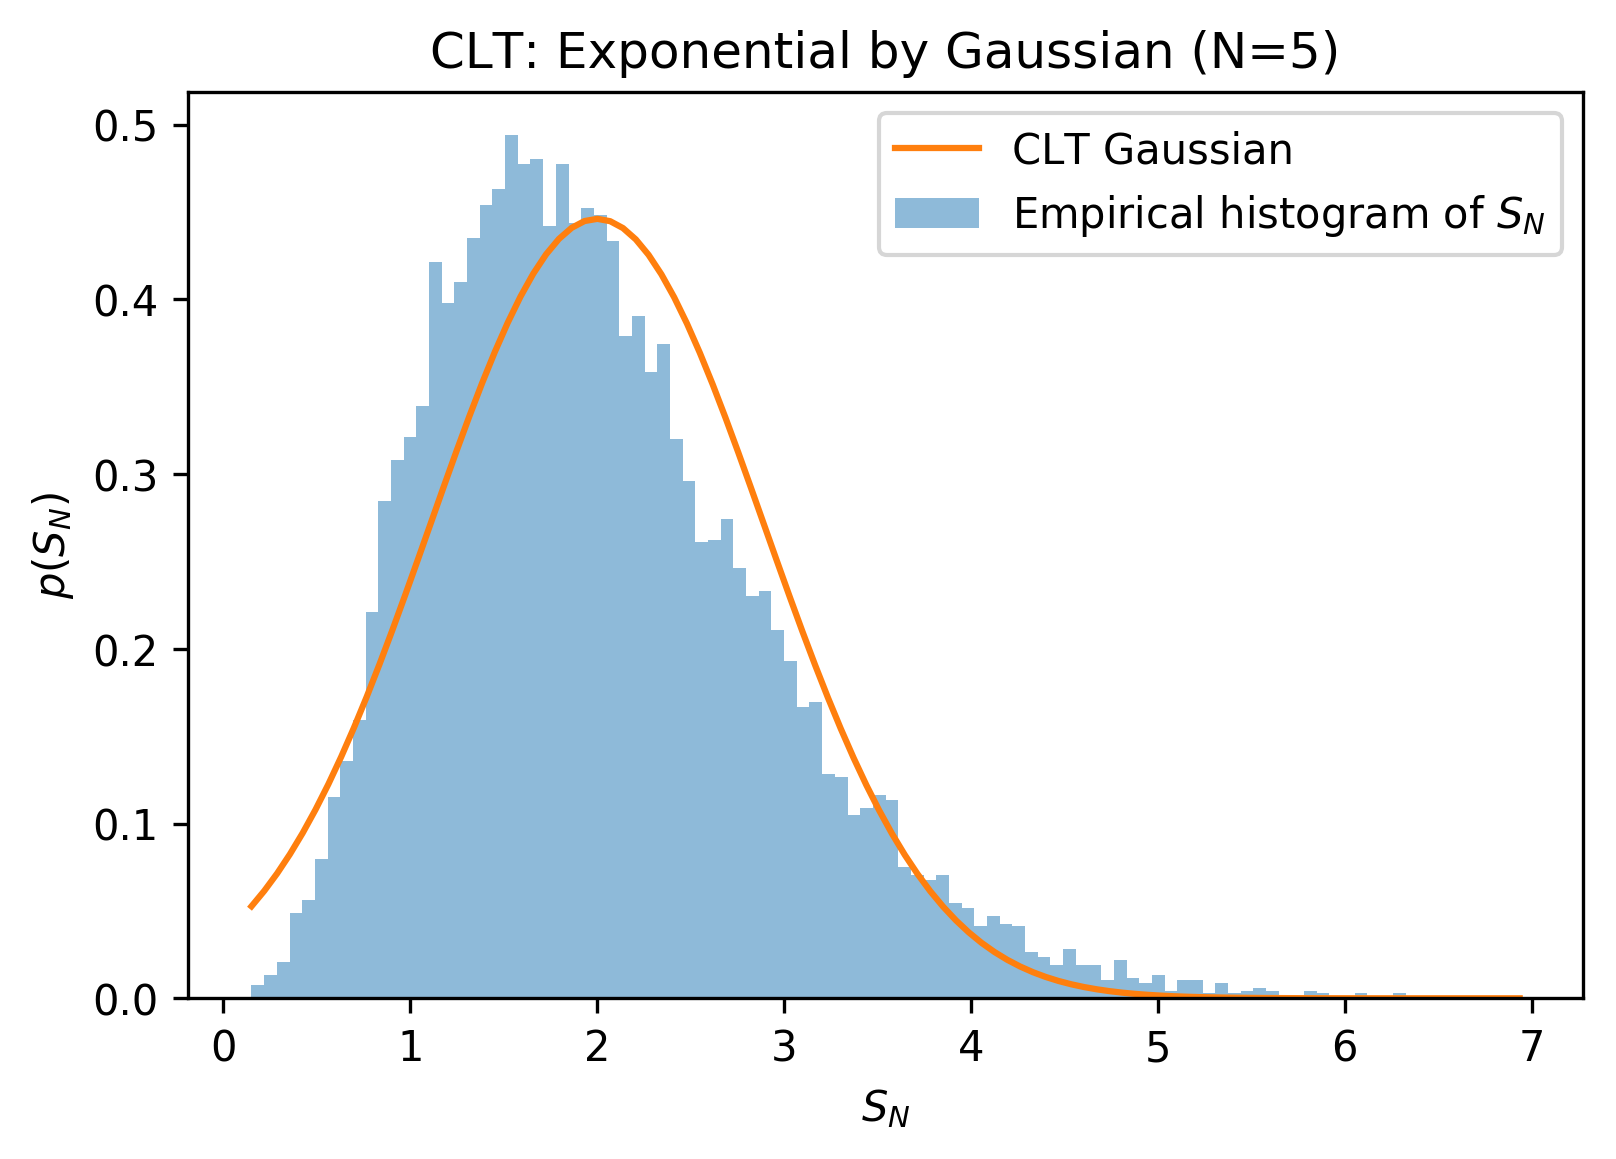

In [22]:
r = 0.5
N = 5   # How many iid variables are we going to sum
M = 10000 # How many times do you want to sample
Ts = np.random.exponential(scale=1./r, size=(N, M))  # Notice that it uses the inverse of the rate.
                                                     # It is always a good idea to look at the documentation
                                                     # if you are unsure.
# These are the samples of SN:
SN = np.sum(Ts, axis=0) / N  # Notice that I am only summing the rows

fig, ax = plt.subplots()
ax.hist(SN, bins=100, normed=True, alpha=0.5, label='Empirical histogram of $S_N$')
mu_CLT = 1. / r             # CLT mean
sigma_CLT = np.sqrt(1. / (N * r**2)) # CLT standard deviation
Ss = np.linspace(SN.min(), SN.max(), 100)
ax.plot(Ss, st.norm(loc=mu_CLT, scale=sigma_CLT).pdf(Ss), label='CLT Gaussian')
ax.set_xlabel('$S_N$')
ax.set_ylabel('$p(S_N)$')
ax.set_title('CLT: Exponential by Gaussian (N=%d)' % N)
plt.legend(loc='best')

### Questions 04

+ Start increase $N$ and observe the convergence.
+ Go back to the Bernoulli distribution. What are its mean and variance? What is the mean and the variance of the Gaussian approximating the sum of idenpdent Bernoulli distributions? Verify this result numerically (copy paste the code above and make the appropriate changes).